## Loading Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('final_review.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,rating,text,label
0,1,Never clean and there r some good employees b...,0
1,1,I was in the store looking for shoes for my 20...,0
2,1,Staff is super friendly but the store is very ...,0
3,1,Nasty and horrible service,0
4,1,We had a flat tire that was barely pumped enou...,0


## LLM-based

In [ ]:
!pip install google-genai

In [ ]:
# Not using the entire dataset
sample_size = min(120, len(df))
df_sample = df.sample(n=sample_size, random_state=42)
print(df_sample.shape)
print(df.shape)

(120, 3)
(12000, 3)


In [ ]:
from google import genai
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

client = genai.Client(api_key=GEMINI_API_KEY)

print("API key loaded successfully from Colab secrets.")

API key loaded successfully from Colab secrets.


In [ ]:
import time
from google.genai import types # Import types here

prompt_instruction = """
Perform sentiment analysis and classify as positive, negative, or neutral.
Return ONLY a number, positive is 2, neutral is 1, negative is 0.
"""

def llm_sentiment_analysis(df_sample, prompt_instruction):
  predictions = []

  for idx, review in enumerate(df_sample['text']):
    try:
      response = client.models.generate_content(
          model = 'gemini-2.5-flash', # Changed model to 'gemini-2.5-flash'
          config=types.GenerateContentConfig(
              temperature=0
          ),
          contents=[prompt_instruction, review] # Pass prompt instruction as part of contents
      )

      pred = int(response.text.strip())
      predictions.append(pred)

      # Rate limiting
      time.sleep(1)

      if idx % 5 == 0:
        print(f"Processed {idx}/{len(df_sample)}")

    except Exception as e:
      print(f"Error processing review {idx}: {e}")
      predictions.append(1) # default is neutral
      time.sleep(5)

  return predictions

In [ ]:
%%time

predictions = llm_sentiment_analysis(df_sample, prompt_instruction)

Processed 0/120
Processed 5/120
Processed 10/120
Processed 15/120
Processed 20/120
Processed 25/120
Processed 30/120
Processed 35/120
Processed 40/120
Processed 45/120
Processed 50/120
Processed 55/120
Processed 60/120
Processed 65/120
Processed 70/120
Processed 75/120
Processed 80/120
Processed 85/120
Processed 90/120
Processed 95/120
Processed 100/120
Processed 105/120
Processed 110/120
Processed 115/120
CPU times: user 559 ms, sys: 39.5 ms, total: 599 ms
Wall time: 5min 34s


In [ ]:
llm_predictions = pd.DataFrame(predictions, columns=['label_llm'])

# Comparing two dataframes ['label']
accuracy = (llm_predictions['label_llm'] == df_sample['label'].reset_index(drop=True)).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.725


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_sample['label'], llm_predictions['label_llm']))

              precision    recall  f1-score   support

           0       0.61      0.95      0.75        40
           1       0.75      0.18      0.29        34
           2       0.86      0.93      0.90        46

    accuracy                           0.72       120
   macro avg       0.74      0.69      0.64       120
weighted avg       0.75      0.72      0.67       120



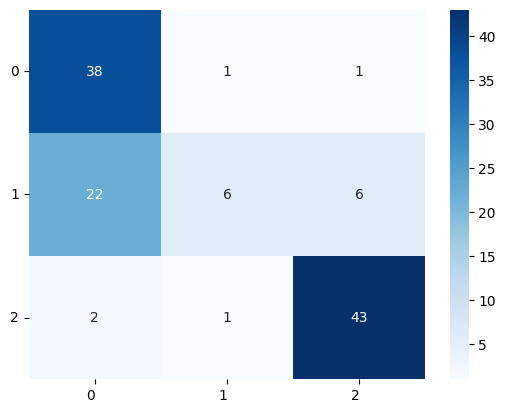

In [ ]:
def visualize_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(df_sample['label'], llm_predictions['label_llm'])
visualize_confusion_matrix(cm)

In [ ]:
# Checking examples where LLM failed
df2 = df_sample.copy()
df2['label_llm'] = llm_predictions['label_llm'].values
df2[df2['label'] != df2['label_llm']]

,rating,text,label,label_llm
6494,3,Ok food. Over priced,1,0
9663,4,Lots of stores,2,1
2221,2,Fast food.,0,1
4617,3,Its convenient,1,2
5224,3,Chicken nuggets way over priced.\nNot a good v...,1,0
7047,3,Line to long,1,0
9290,4,Wow a lot has changed since I was younger doin...,2,0
6118,3,Very thin walls. Everyone can hear you when yo...,1,0
5042,3,Wish they carried women's flannel lined jeans,1,0
7238,3,Could be good but staff needs help,1,0


In [ ]:
# Looking at examples that it got correct
df2[df2['label'] == df2['label_llm']].head()

,rating,text,label,label_llm
1935,1,It was pretty dead by the time we got there an...,0,0
1720,1,It sucks bad,0,0
9120,4,Great steaks!!!,2,2
360,1,Ordered a double pepperoni pizza got a regular...,0,0
5277,3,Nice friendly place. Drinks are overpriced for...,1,1


### LLM Results (zero-shot)

I used the following prompt and got an accuracy of 72.5% (BERT got 71%):

```
Perform sentiment analysis and classify as positive, negative, or neutral.

Return ONLY a number, positive is 2, neutral is 1, negative is 0.
```

For some of the examples it failed, we can see why it did. For example, one was review "Good food prices could be better", which the LLM marked as `neutral` but it was a `positive`. I think they meant to say "Good. Prices could be better though!", but that's just real-world datasets no? Not everything will be formatted nice. But not just that, this statement itself is indeed `neutral` I would say. But the person still gave it a 4+ rating, therefore, according to my data balance choice of the ratings, this would be considered a `positive`. So, you're model may not always be wrong literally, but technically it will be according to the data. This could very much apply to BERT as well. And honestly, accuracy doesn't mean everything sometimes. The goal of this was to see if they could really understand the semantics in the first place. Which the LLM no-doubt did a good job.

That being said, some examples it got wrong did confuse me. For example, the review "A bit inconsiderate workers at time". This is clearly a negative example, but it marked it as `neutral` for some reason. When clearly it's a negative review. There are a few more examples where I could get a better accuracy by telling the model how I structured my dataset and came up with my models.

Anyways, with a simple prompt, it did a great job overall picking up the semantics. In terms of F1, like the BERT, it did fairly well with `positive` and `negative` classes but seemed to struggle the most with `neutral`.

### One-shot prompting

I'll be using a more calibrated prompt with additional info to see if results improve.

In [ ]:
calibrated_prompt = """
You are performing sentiment analysis on user reviews.

Classify the review into ONE of the following classes based on overall sentiment:

Negative (0):
- Clear dissatisfaction, complaints, or negative experience
- Negative descriptors about service, staff, product, or experience (e.g., rude, inconsiderate, bad, poor, disappointing)

Neutral (1):
- Mixed sentiment (both positive and negative)
- Mild criticism without strong emotion
- Unclear, factual, or ambiguous opinion

Positive (2):
- Clear satisfaction, praise, or recommendation
- Overall positive experience, even if minor issues are mentioned

Rules:
- If both praise and criticism appear, choose the overall tone.
- If the sentiment is unclear or evenly mixed, choose Neutral.
- Short or fragment reviews with negative descriptors should be classified as Negative.

Return ONLY a single number:
2 for Positive
1 for Neutral
0 for Negative
"""

In [ ]:
%%time

predictions = llm_sentiment_analysis(df_sample, calibrated_prompt)

Processed 0/120
Processed 5/120
Processed 10/120
Processed 15/120
Processed 20/120
Processed 25/120
Processed 30/120
Processed 35/120
Processed 40/120
Processed 45/120
Processed 50/120
Error processing review 51: invalid literal for int() with base 10: 'Please provide the review you would like me to classify.'
Processed 55/120
Processed 60/120
Processed 65/120
Processed 70/120
Processed 75/120
Processed 80/120
Processed 85/120
Processed 90/120
Processed 95/120
Processed 100/120
Processed 105/120
Processed 110/120
Processed 115/120
CPU times: user 578 ms, sys: 29.6 ms, total: 607 ms
Wall time: 6min 14s


In [ ]:
cal_llm_predictions = pd.DataFrame(predictions, columns=['label_llm'])

# Comparing two dataframes ['label']
accuracy = (cal_llm_predictions['label_llm'] == df_sample['label'].reset_index(drop=True)).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.7416666666666667


## Rule-based

In [ ]:
POSITIVE = {
	    "good", "great", "excellent", "amazing", "awesome", "positive", "fortunate",
    	"smooth", "successful", "well", "improved", "love", "nice", "happy",
    	"beneficial", "effective", "efficient", "fast", "quick", "stable",
    	"resolved", "fix", "fixed", "handle", "handled", "progress",
    	"supportive", "reliable", "success", "clean"
}
POSITIVE_WORDS = set(POSITIVE)

NEGATIVE = {
	    "bad", "terrible", "awful", "negative", "unfortunate",
    	"slow", "sluggish", "fail", "failed", "failure", "error", "errors",
    	"issue", "issues", "problem", "problems", "bug", "bugs",
    	"timeout", "crash", "broken", "downtime", "unstable",
    	"delay", "delayed", "incorrect", "poor", "worse", "worst",
    	"unexpected", "critical", "urgent",
    	"outdated", "dependency", "incident"
}
NEGATIVE_WORDS = set(NEGATIVE)

NEGATION = {"not", "no", "never", "none", "didn't", "won't", "cannot", "can't"}
NEGATION_WORDS = set(NEGATION)

STOP_WORDS = {
    # Articles
    "a", "an", "the",

    # Pronouns
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves",
    "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself",
    "it", "its", "itself", "they", "them", "their", "theirs", "themselves",

    # Prepositions
    "in", "on", "at", "by", "for", "with", "about", "against", "between",
    "into", "through", "during", "before", "after", "above", "below",
    "to", "from", "up", "down", "of", "off", "over", "under",

    # Conjunctions
    "and", "but", "or", "nor", "so", "yet", "because", "as", "if",
    "when", "where", "while", "although", "though", "unless", "until",

    # Common verbs
    "is", "am", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing",
    "will", "would", "should", "could", "may", "might", "must", "can",

    # Question words
    "what", "which", "who", "whom", "whose", "why", "how",

    # Other common words
    "this", "that", "these", "those", "there", "here",
    "all", "both", "each", "few", "more", "most", "other", "some", "such",
    "no", "not", "only", "own", "same", "than", "too", "very",
    "just", "now", "then", "once", "also", "again", "further",
    "any", "every", "either", "neither", "another",
    "out", "such", "via"
}

STOP_WORDS_SET = set(STOP_WORDS)

In [ ]:
import re

def regex_tokenizer(df_sample):
  token_list = []
  for idx, text in enumerate(df_sample['text']):
    try:
      pattern = re.compile(
        r"""
        https?://\S+                                      # URLs
        |[A-Za-z0-9_.+-]+@[A-Za-z0-9-]+\.[A-Za-z0-9-.]+   # emails
        |\$(?:\d{1,3}(?:,\d{3})*|\d+)(?:\.\d+)?[KMBkmb]?  # money: $88.3B, $1.23, $90M
        |\d+(?:\.\d+)?%                                   # percentages: 3.2%, 12%
        |[0-9]{1,2}:[0-9]{2}                              # times: 3:00, 12:30
        |[A-Za-z0-9]+(?:[-'][A-Za-z0-9]+)*                # words w/ internal - or '
        """,
        re.VERBOSE,
      )

      matches = pattern.finditer(text)
      cleaned = [m.group().lower() for m in matches]
      tokens = [token for token in cleaned if token not in STOP_WORDS_SET]
      token_list.append(tokens)
    except Exception as e:
      print(f"Error processing review {idx}: {e}")
      token_list.append([])
      time.sleep(5)

  return token_list


In [ ]:
regex_tokens = regex_tokenizer(df_sample)
print(regex_tokens[0])
print(df_sample['text'].iloc[0])

['worst', 'store', 'midwest', 'friend', 'went', 'day', 'got', 'kicked', 'racist', 'worker', "wasn't", 'even', 'wearing', 'uniform', 'scared', 'helpless', 'innocent', 'white', 'friend', 'told', 'follow', 'back', 'proof', 'anything', 'tried', 'shoes', 'minute', 'jumped', 'called', 'police', 'told', 'stupid', 'story', 'made', 'pay', 'shoes', "didn't", 'even', 'give', 'kid', 'shoes', 'white', 'pocketed', 'money', 'yelled', 'never', 'come', 'back', 'knows', 'white', 'faces', 'felt', 'really', 'scared', 'rights', 'caucasian', 'human', 'heartland', 'america', 'threatens', 'mean', 'bully', 'never', 'shop', 'racist', 'store']
This is the WORST STORE in the Midwest my friend went there the other day and got kicked out because some racist worker that wasn't even wearing uniform and scared my helpless innocent white friend and told him to follow her out back and she had no proof of anything he tried on shoes for a minute and she jumped on him and she called the police and told him some stupid stor

In [ ]:
print(type(regex_tokens))
print(type(regex_tokens[0]))

<class 'list'>
<class 'list'>


In [ ]:
# regex_tokens is a double list. Each index is a list of tokens.

def regex_sentiment_analysis(list_of_tokens):
    predictions = []
    for tokens_for_review in list_of_tokens:
        pos = 0
        neg = 0
        for i, w in enumerate(tokens_for_review):
            if i > 0 and i < len(tokens_for_review)-1:
                if w in POSITIVE_WORDS and tokens_for_review[i-1] not in NEGATION_WORDS:
                    pos += 1
                elif w in POSITIVE_WORDS and tokens_for_review[i-1] in NEGATION_WORDS:
                    neg += 1
                elif w in NEGATIVE_WORDS and tokens_for_review[i-1] in NEGATION_WORDS:
                    pos += 1
                elif w in NEGATIVE_WORDS and tokens_for_review[i-1] not in NEGATION_WORDS:
                    neg += 1
        sentiment_score = pos - neg
        if sentiment_score > 0:
          predictions.append(2)
        elif sentiment_score < 0:
          predictions.append(0)
        elif sentiment_score == 0:
          predictions.append(1)
    return predictions

In [ ]:
%%time

predictions = regex_sentiment_analysis(regex_tokens)

CPU times: user 453 µs, sys: 0 ns, total: 453 µs
Wall time: 458 µs


In [ ]:
predictions

rb_predictions = pd.DataFrame(predictions, columns=['label_rb'])

# Comparing two dataframes ['label']
accuracy = (rb_predictions['label_rb'] == df_sample['label'].reset_index(drop=True)).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.44166666666666665


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_sample['label'], rb_predictions['label_rb']))

              precision    recall  f1-score   support

           0       1.00      0.12      0.22        40
           1       0.33      0.85      0.48        34
           2       0.70      0.41      0.52        46

    accuracy                           0.44       120
   macro avg       0.68      0.46      0.41       120
weighted avg       0.70      0.44      0.41       120



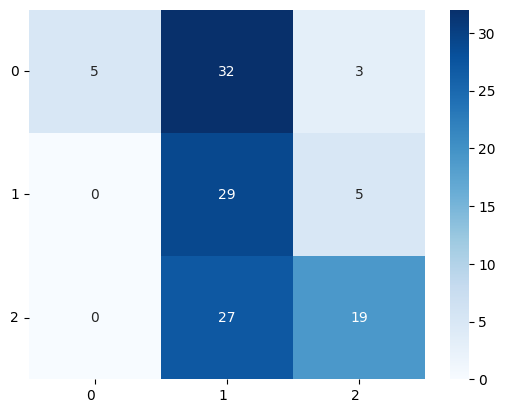

In [ ]:
def visualize_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(df_sample['label'], rb_predictions['label_rb'])
visualize_confusion_matrix(cm)

## Rule-based Analysis

Haha, 45% accuracy with rule-based. Honestly not bad considering how small my list is for positive and negative words. It also did a better job picking up `neutral` than LLM and BERT but honestly that's primarily because most of the times the postive words just cancelled with the negative words. If you look at rule-based predictions, most of the times it's prediction is a 1 or `neutral`, so sure it will be 'better' than the LLM and BERT at picking up `neutral` classes.

From some of the examples it got wrong from below, all the wrong examples it predicted `neutral`. Picking `neutral` just means that your logic has mixed feelings essentially and isn't committed to either `positive` or `negative`. It's ambiguity.

In [ ]:
# Checking examples where rule-based failed
df2 = df_sample.copy()
df2['label_rb'] = rb_predictions['label_rb'].values
df2[df2['label'] != df2['label_rb']].head()

,rating,text,label,label_rb
1935,1,This is the WORST STORE in the Midwest my frie...,0,1
6494,3,The Wendy's on Southeast 14th is wonderful as...,1,2
1720,1,Over priced... my girl was mad as... we're not...,0,1
9120,4,Good bowling,2,1
9663,4,Love it,2,1


In [ ]:
# Looking at examples that rule-based got correct
df2[df2['label'] == df2['label_rb']].head()

,rating,text,label,label_rb
360,1,Worst mail carrier ever. She's always on her ...,0,0
5277,3,Watched guy putting away meds be rude to pharm...,1,1
4617,3,Roads really need work not safe for vehichles,1,1
468,1,Employees at this store need some training in ...,0,0
5224,3,They messed up my order and knew what they did...,1,1


If you were to use a larger list of more postive and negative words, as well as negation words, you may get better results but maybe not. There are definitely limitations to rule-based and my logic. At the end of the day, it doesn't capture the semantics of the text and is purely syntax based.

## Checking prediction time & accuracy for the whole dataset (all 12k)

In [ ]:
regex_tokens = regex_tokenizer(df)
print(regex_tokens[0])
print(df['text'].iloc[0])

['never', 'clean', 'r', 'good', 'employees', 'bad', 'rude', 'employees', 'coure', 'bad', "ones's", 'makes', 'good', 'one', 's', 'suffer', 'need', 'sonething', 'bad', "one's"]
Never clean and there r some  good employees but there bad rude employees. And of coure the bad ones's makes the good one,'s suffer. Need to sonething with the bad one's.


In [ ]:
%%time

predictions = regex_sentiment_analysis(regex_tokens)

CPU times: user 33.3 ms, sys: 867 µs, total: 34.2 ms
Wall time: 35.3 ms


In [ ]:
predictions

rb_predictions = pd.DataFrame(predictions, columns=['label_rb'])

accuracy = (rb_predictions['label_rb'] == df['label'].reset_index(drop=True)).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.4093333333333333


In [ ]:
print(classification_report(df['label'], rb_predictions['label_rb']))

              precision    recall  f1-score   support

           0       0.70      0.12      0.20      4000
           1       0.36      0.73      0.48      4000
           2       0.49      0.38      0.43      4000

    accuracy                           0.41     12000
   macro avg       0.51      0.41      0.37     12000
weighted avg       0.51      0.41      0.37     12000



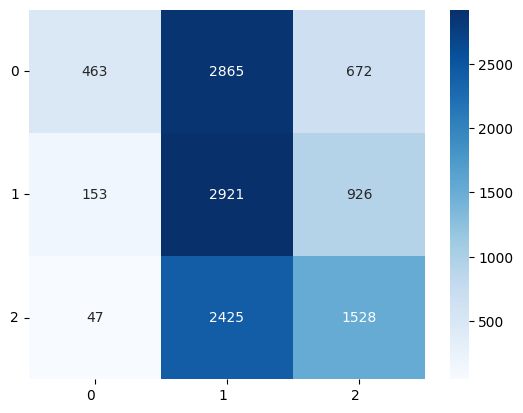

In [ ]:
def visualize_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")

cm = confusion_matrix(df['label'], rb_predictions['label_rb'])
visualize_confusion_matrix(cm)